In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import copy

# Kalman smoother

In [102]:
def __kalman_forward_update__(xhat_fm, P_fm, y, u, A, B, C, R, Q):
    '''
    H = C
    Phi = A
    Gamma = B
    '''
    I = np.matrix(np.eye(A.shape[0]))
    gammaW = np.matrix(np.eye(A.shape[0]))

    K_f = P_fm*C.T*(C*P_fm*C.T + R).I

    if y[0,0] is not None:
        xhat_fp = xhat_fm + K_f*(y - C*xhat_fm)
        P_fp = (I - K_f*C)*P_fm
    else: # no new data
        xhat_fp = xhat_fm
        P_fp = P_fm

    xhat_fm = A*xhat_fp + B*u

    P_fm = A*P_fp*A.T + gammaW*Q*gammaW.T

    return xhat_fp, xhat_fm, P_fp, P_fm

def __kalman_forward_filter__(xhat_fm, P_fm, y, u, A, B, C, R, Q):
    assert type(xhat_fm) is np.matrix
    assert type(P_fm) is np.matrix
    assert type(A) is np.matrix
    assert type(B) is np.matrix
    assert type(C) is np.matrix
    assert type(R) is np.matrix
    assert type(Q) is np.matrix
    assert type(y) is np.matrix
    if u is None:
        u = np.matrix(np.zeros([B.shape[1], y.shape[1]]))
    assert type(u) is np.matrix
    
    N = y.shape[1]

    xhat_fp = None
    P_fp = []
    P_fm = [P_fm]

    for i in range(y.shape[1]):
        _xhat_fp, _xhat_fm, _P_fp, _P_fm = __kalman_forward_update__(xhat_fm[:, -1], P_fm[-1], y[:, i], u[:, i], 
                                                                 A, B, C, R, Q)
        if xhat_fp is None:
            xhat_fp = _xhat_fp
        else:
            xhat_fp = np.hstack((xhat_fp, _xhat_fp))
        xhat_fm = np.hstack((xhat_fm, _xhat_fm))
        
        P_fp.append(_P_fp)
        P_fm.append(_P_fm)

    return xhat_fp, xhat_fm, P_fp, P_fm

def __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A):
    N = xhat_fp.shape[1]

    xhat_smooth = copy.copy(xhat_fp)
    P_smooth = copy.copy(P_fp)
    for t in range(N-2, -1, -1):
        L = P_fp[t]*A.T*P_fm[t].I
        xhat_smooth[:,t] = xhat_fp[:,t] + L*(xhat_smooth[:,t+1] - xhat_fm[:,t+1])
        P_smooth[t] = P_fp[t] - L*(P_smooth[t+1] - P_fm[t+1])
    
    return xhat_smooth, P_smooth

# Data

US confirmed new daily cases, not 7-day averaged. 

Text(0,0.5,'New daily cases')

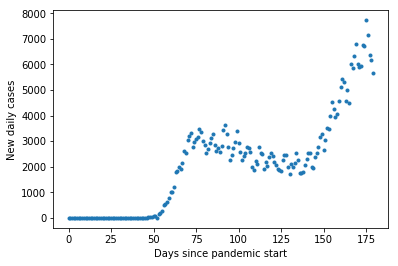

In [51]:
df = pandas.read_csv('covid_us_confirmed_072020.csv')

columns_to_drop = []
for col in df.columns:
    if '/' not in col:
        columns_to_drop.append(col)
        
df = df.drop(columns=columns_to_drop)
covid = np.diff( df.sum(axis=0).values ) / 10.
dt = 1 # 1 day
t = np.arange(0, len(covid))

plt.plot(t, covid, '.')
plt.xlabel('Days since pandemic start')
plt.ylabel('New daily cases')

# Take a subset of data

And run kalman smoother to predict N days forward

In [103]:
daysofdata = 100
ndayspred = 100

In [104]:
x = covid[0:daysofdata]

# Kalman smooth

In [105]:
# I tuned these manually to "look good".. we have no empirical data to tell us what is correct.
# They can be tuned statistically using an expectation maximization approach
r = 100000 # How bad is your sensor (smaller means it is more reliable)
q = 100 # How bad is your model (smaller means it is better)

# Using a constant velocity model, meaning, without additional information, we assume the number of new daily
# cases increases at the same rate as yesterday
A = np.matrix([[1, dt], [0, 1]])
B = np.matrix([[0], [0]])
C = np.matrix([[1, 0]])
R = np.matrix([[r]])
Q = np.matrix([[1e-16, 0], [0, q]])
x0 = np.matrix([[x[0]], [0]])
P0 = np.matrix(100*np.eye(2))
y = np.matrix( np.hstack([x, [None]*ndayspred]) ) # None will force a prediction
u = None
    
# Kalman filter
xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, y, u, A, B, C, R, Q)
# Kalman smooth
xhat_smooth, P_smooth = __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A)

# Pull out the data we want

# The smoothed new daily cases
covid_smooth = np.array(np.ravel(xhat_smooth[0,:]), dtype=float)

# The covariance of the smoothed daily cases: gives sense of how reliable the estimate is 
covid_covar = np.array([P_smooth_i[0,0]  for P_smooth_i in P_smooth], dtype=float)

# Time (days)
t = np.arange(0, len(covid_smooth))

# Plot

(0, 10000)

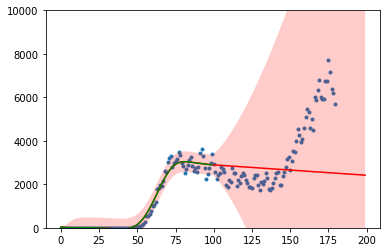

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111)


ax.plot(t[0:-1*ndayspred], covid_smooth[0:-1*ndayspred], color='green')
ax.plot(t, covid_smooth, color='red', zorder=-10)

ax.fill_between(t, covid_smooth-3*np.sqrt(covid_covar),
                 covid_smooth+3*np.sqrt(covid_covar), facecolor='red', alpha=0.2, edgecolor='none', zorder=-20)

plt.plot(np.arange(0, len(covid)), covid, '.', zorder=-30)

plt.ylim(0, 10000)